In [211]:
import dask.dataframe as dd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [212]:
%matplotlib inline

In [213]:
# TRAIN_PATH = "/Users/tarunkukreja/Desktop/Desk/ML/New\ York\ Taxi\ Fare\ Prediction/new-york-city-taxi-fare-prediction\ \(1\)/train.csv"
TRAIN_PATH = "/Users/tarunkukreja/Desktop/Desk/ML/New_York_Taxi_Fare_Prediction/dataset/train.csv"
TEST_PATH = "/Users/tarunkukreja/Desktop/Desk/ML/New_York_Taxi_Fare_Prediction/dataset/test.csv"



# Reading of training data 

In [214]:
# data = dd.read_csv(TRAIN_PATH)

In [215]:
# len(data) # the data is randomly ordered

## the actual dataset contains fifty five million four hundred twenty three thousand four hundred eighty rows

In [216]:
## reading first 50000 rows of randomly ordered data
data = dd.read_csv(TRAIN_PATH).head(50000)

In [217]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734371,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


## Data Cleaning and Explorating

In [218]:
data = data.dropna()
data = data.drop(labels='key', axis=1)
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [219]:
# taking the 1.5% and 98.5% values of columns to remove outliers
for col in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
    print('2.5% = {} \t 97.5% ={}'.format(np.percentile(data[col], 2.5), np.percentile(data[col], 97.5)))
                            

2.5% = 40.6446359 	 97.5% =40.796687075
2.5% = -74.009572075 	 97.5% =-73.781879925
2.5% = 40.642556 	 97.5% =40.80622775
2.5% = -74.01056505 	 97.5% =-73.7832712198


In [220]:
# Remove latitude and longtiude outliers --> based on the range between 2.5% and 97.5% values
data = data.loc[data['pickup_latitude'].between(40, 42)]
data = data.loc[data['pickup_longitude'].between(-75, -72)]
data = data.loc[data['dropoff_latitude'].between(40, 42)]
data = data.loc[data['dropoff_longitude'].between(-75, -72)]

In [221]:
print("There are {} negative fares.".format(len(data[data['fare_amount'] < 0])))

There are 5 negative fares.


Text(0.5,1,'Visualisation of Fares')

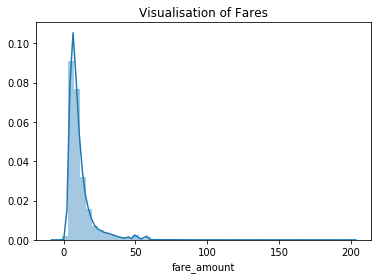

In [222]:
# some data visualisation

plt.figure()
sns.distplot(data['fare_amount'])
plt.title('Visualisation of Fares')

### the above plot tells us that we can have fares between 2.5(this is from the new york taxi fares standards) and 100

In [223]:
# limit of fares only between $2.5 and $100
data = data[data['fare_amount'].between(left = 2.5, right = 100)]

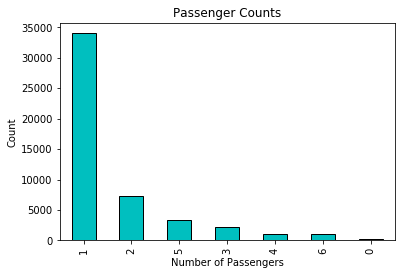

In [224]:
#graph of passenger counts to see its suspicious values
data['passenger_count'].value_counts().plot.bar(color = 'c', edgecolor = 'k');
plt.title('Passenger Counts'); 
plt.xlabel('Number of Passengers'); 
plt.ylabel('Count');

In [225]:
# removing passenger count greater than 6 since the above viz shows no. of passengers not greater than 0
data = data.loc[data['passenger_count'] < 6]

In [226]:
len(data)

47953

Text(0.5,1,'Dropoff Locations')

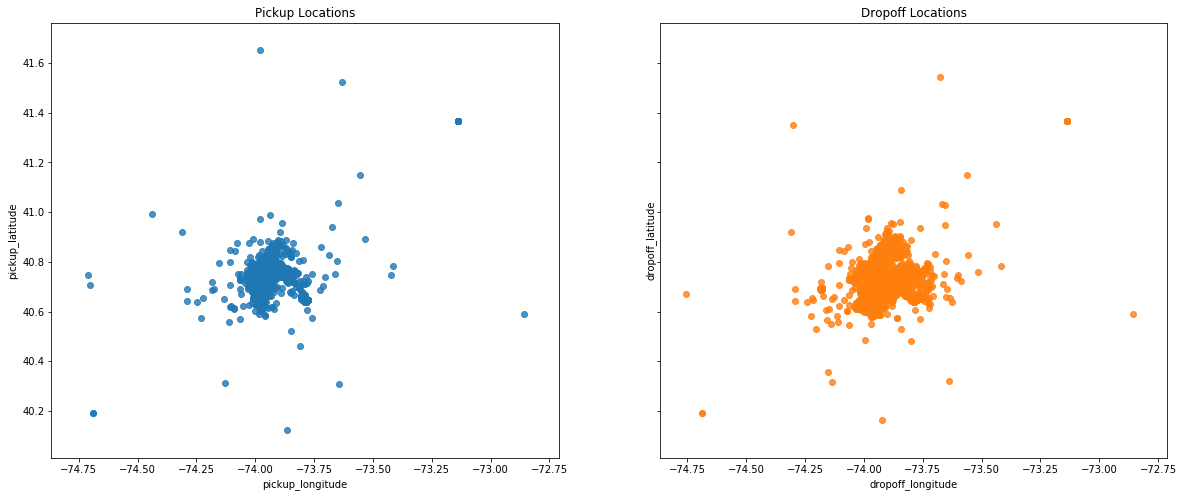

In [227]:
# DIstribution of Pickup and Dropoff 

fig, axes = plt.subplots(1, 2, figsize = (20, 8), sharex=True, sharey=True)
axes = axes.flatten()
# data = data.sample(10000, random_state = RSEED)
# Plot Longitude (x) and Latitude (y)
sns.regplot('pickup_longitude', 'pickup_latitude', data, fit_reg = False, 
            ax = axes[0] );

sns.regplot('dropoff_longitude', 'dropoff_latitude', data, fit_reg = False, 
             ax = axes[1]);
axes[0].set_title('Pickup Locations')
axes[1].set_title('Dropoff Locations')

##   Feature Engineering

#### One feature that is very important here is the distance, since distance isn't there in the given dataset. Since fares highly depend upon distance we can get some sort of distance by calculating the difference between pickup and drop off coordinates

In [228]:
# Absolute difference in latitude and longitude
data['abs_lat_diff'] = (data['dropoff_latitude'] - data['pickup_latitude']).abs()
data['abs_lon_diff'] = (data['dropoff_longitude'] - data['pickup_longitude']).abs()

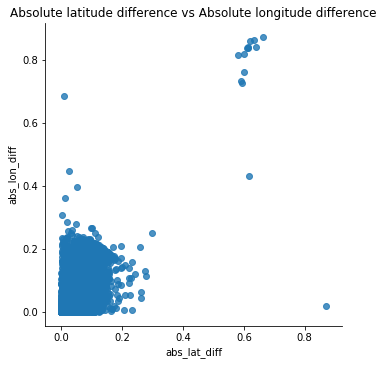

In [229]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff',
           data, fit_reg = False);
plt.title('Absolute latitude difference vs Absolute longitude difference');

In [230]:
# checking for 0 difference in latitute and longitude - same pickup and drop off location
no_diff = data[(data['abs_lat_diff'] == 0) & (data['abs_lon_diff'] == 0)]
no_diff.shape

(528, 9)

In [231]:
# Bin the fare and convert to string
data['fare-bin'] = pd.cut(data['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# Uppermost bin
data.loc[data['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Adjust bin so the sorting is correct
data.loc[data['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'


In [232]:
list(enumerate(data['fare-bin'].unique()))

[(0, '(0, 5]'),
 (1, '(15, 20]'),
 (2, '(05, 10]'),
 (3, '(10, 15]'),
 (4, '(20, 25]'),
 (5, '(30, 35]'),
 (6, '[45+]'),
 (7, '(25, 30]'),
 (8, '(35, 40]'),
 (9, '(40, 45]')]

In [233]:
palette = sns.color_palette('muted', 10)

In [234]:
# Create a color mapping based on fare bins
color_mapping = {fare_bin: palette[i] for i, fare_bin in enumerate(data['fare-bin'].unique())}
color_mapping

{'(0, 5]': (0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 '(05, 10]': (0.41568627450980394, 0.8, 0.39215686274509803),
 '(10, 15]': (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 '(15, 20]': (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 '(20, 25]': (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 '(25, 30]': (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 '(30, 35]': (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 '(35, 40]': (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 '(40, 45]': (0.5098039215686274, 0.7764705882352941, 0.8862745098039215),
 '[45+]': (0.8627450980392157, 0.49411764705882355, 0.7529411764705882)}

In [235]:
data['color'] = data['fare-bin'].map(color_mapping)

In [236]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,fare-bin,color
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.009041,0.002701,"(0, 5]","(0.282352941176, 0.470588235294, 0.81568627451)"
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.070701,0.036780,"(15, 20]","(0.933333333333, 0.521568627451, 0.290196078431)"
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.010708,0.008504,"(05, 10]","(0.41568627451, 0.8, 0.392156862745)"
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.024949,0.004437,"(05, 10]","(0.41568627451, 0.8, 0.392156862745)"
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.015754,0.011440,"(05, 10]","(0.41568627451, 0.8, 0.392156862745)"


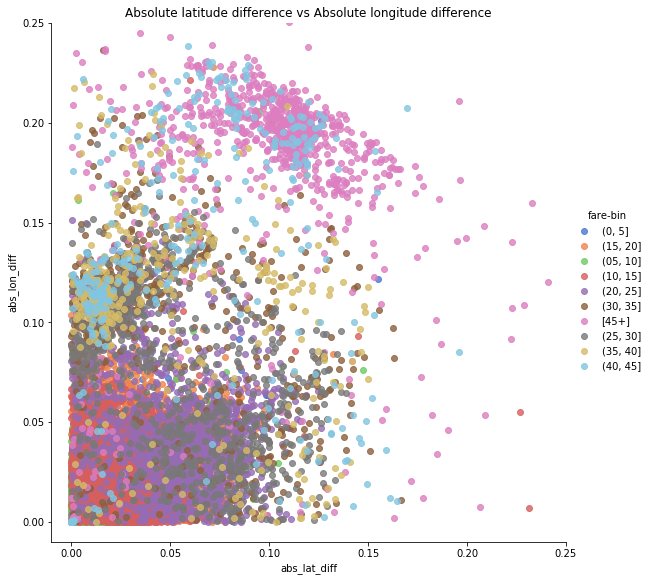

In [237]:
# plotting based on fare bins 
sns.lmplot('abs_lat_diff', 'abs_lon_diff', data, hue = 'fare-bin', size = 8, palette=palette,
           fit_reg = False);
plt.xlim((-0.01, .25)); 
plt.ylim((-0.01, .25))
plt.title('Absolute latitude difference vs Absolute longitude difference');

##### It does seem that the rides with a larger absolute difference in both longitude and latitude tend to cost more.

# Minkowski Distance ---> Manhattan and Euclidean distance

In [238]:
def minkowski_distance(x1, x2, y1, y2, p):
    return (((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p))

In [239]:
minkowski_distance(0, 3, 0, 4, 1)

7

In [240]:
data['euclidean'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 2)

data['mahattan'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 1)





In [241]:
data.groupby('fare-bin')['mahattan'].agg(['mean', 'count'])

,mean,count
fare-bin,,
"(0, 5]",0.012505,7381
"(05, 10]",0.025491,22558
"(10, 15]",0.048197,9548
"(15, 20]",0.071651,3510
"(20, 25]",0.098144,1554
"(25, 30]",0.123891,958
"(30, 35]",0.143953,735
"(35, 40]",0.159106,416
"(40, 45]",0.193199,334


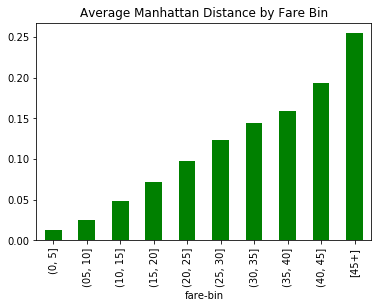

In [242]:
data.groupby('fare-bin')['mahattan'].mean().plot.bar(color = 'g');
plt.title('Average Manhattan Distance by Fare Bin');

##### Here we can see there is a correlation between the fares and the Manhattan distance

Text(0,0.5,'Density')

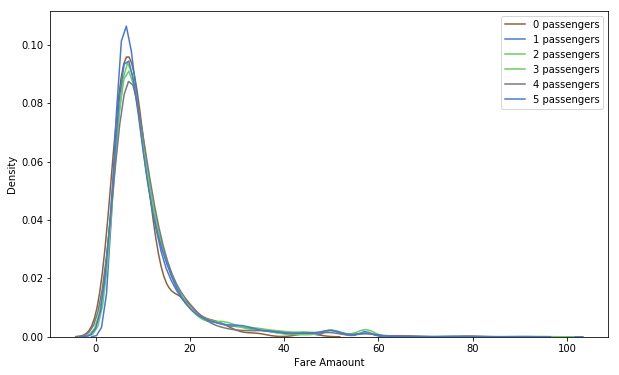

In [243]:
plt.figure(figsize = (10, 6))


for p, grouped in data.groupby('passenger_count'):
    sns.kdeplot(grouped['fare_amount'], label = '{} passengers'.format(p), color = list(grouped['color'])[0]);
plt.xlabel('Fare Amaount')
plt.ylabel('Density')

In [244]:
data.groupby('passenger_count')['fare_amount'].agg(['mean', 'count'])

,mean,count
passenger_count,,
0,9.489308,159
1,11.158416,34027
2,11.997327,7251
3,11.243597,2146
4,11.290313,990
5,11.308728,3380


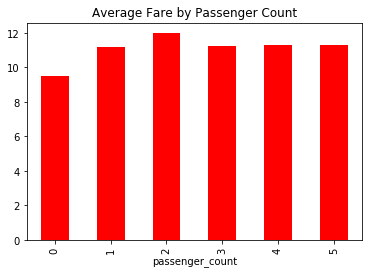

In [245]:
data.groupby('passenger_count')['fare_amount'].mean().plot.bar(color='r')
plt.title('Average Fare by Passenger Count');

#### there is a small difference for passenger count vs fares

## Reading test data

In [246]:
test = dd.read_csv(TEST_PATH).head(2000)

## Create the same features for test data 

In [247]:
test['abs_lat_diff'] = (test['dropoff_latitude'] - test['pickup_latitude']).abs()
test['abs_lon_diff'] = (test['dropoff_longitude'] - test['pickup_longitude']).abs()

In [248]:
test_id = list(test.pop('key')) # drops off the key columns off the frame but the test_id will contain the list of all the keys 

In [249]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.000000,2000.000000
mean,-73.975474,40.750198,-73.974214,40.750483,1.0,0.021325,0.023265
std,0.036126,0.029286,0.035042,0.032762,0.0,0.022461,0.033128
min,-74.252193,40.573143,-74.263242,40.568973,1.0,0.000000,0.000000
25%,-73.992464,40.735112,-73.991009,40.734797,1.0,0.007106,0.006475
50%,-73.982382,40.753036,-73.980156,40.753934,1.0,0.014782,0.013482
75%,-73.967856,40.767182,-73.963553,40.768612,1.0,0.027127,0.025315
max,-73.776711,41.069660,-73.741922,41.051657,1.0,0.190650,0.233482


In [250]:
# adding manhattan distance column
test['manhattan'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 1)

### The manhattan and euclidean distances aren'nt actually the absolute distances they are just relative distances, 
### hence we need absolute distances which can be calculated by Haversine formula which calculates the shortest distance between 2 points on a sphere along the sphere 
### https://en.wikipedia.org/wiki/Haversine_formula



In [251]:
# Radius of the earth in kilometers
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """   
    source: https://stackoverflow.com/a/29546836 

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

In [252]:
## adding haversine distance to train and test data

data['haversine'] =  haversine_np(data['pickup_longitude'], data['pickup_latitude'],
                         data['dropoff_longitude'], data['dropoff_latitude']) 

test['haversine'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                         test['dropoff_longitude'], test['dropoff_latitude'])

In [253]:
data.groupby('fare-bin')['haversine'].agg(['mean', 'count'])

,mean,count
fare-bin,,
"(0, 5]",0.938184,7381
"(05, 10]",1.943108,22558
"(10, 15]",3.708523,9548
"(15, 20]",5.553124,3510
"(20, 25]",7.572781,1554
"(25, 30]",9.413761,958
"(30, 35]",10.793932,735
"(35, 40]",11.842647,416
"(40, 45]",13.938613,334


### It does seem there is a correlation between haversine distance and fare. The larger haversine distances tend to have larger fares as expected.

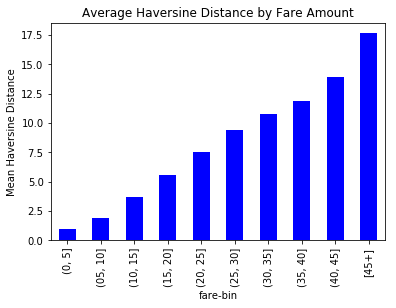

In [254]:
data.groupby('fare-bin')['haversine'].mean().sort_index().plot.bar(color = 'b');
plt.title('Average Haversine Distance by Fare Amount');
plt.ylabel('Mean Haversine Distance');

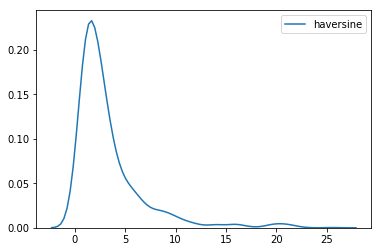

In [255]:
sns.kdeplot(test['haversine'])

#### The above figure shows that most of the distances are from 0-5 kms

## Let's find the correlation between the fare_amount and other features

In [256]:
# drop off euclidean column since coonsidering manhattan distance for now 
data.drop('euclidean', axis=1,inplace=True)

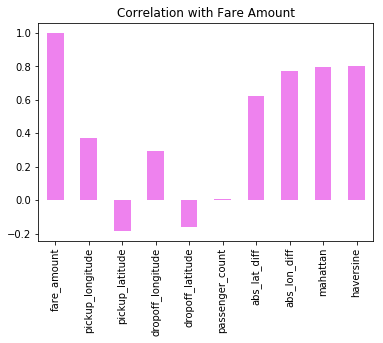

In [257]:
correlation_matrix = data.corr()
correlation_matrix['fare_amount'].plot.bar(color='violet')
plt.title('Correlation with Fare Amount');

### the above plot shows a positive correlation between the distance features and the fare_amount

In [258]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [259]:
lr = LinearRegression()

In [260]:
RSEED = 100

In [261]:
## y we have to predict hence data['fare_amount'] as the 2nd argument

X_train, X_valid, y_train, y_valid = train_test_split(data, 
                                                      data['fare_amount'], 
                                                      test_size=2000, random_state=RSEED, 
                                                      stratify = data['fare-bin'])





In [262]:
lr.fit(X_train[['abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [263]:
print('Intercept', round(lr.intercept_, 4))
print('abs_lat_diff coef: ', round(lr.coef_[0], 4), 
      'abs_lon_diff coef:', round(lr.coef_[1], 4),
      'passenger_count coef:', round(lr.coef_[2], 4))


('Intercept', 5.5646)
('abs_lat_diff coef: ', 96.6053, 'abs_lon_diff coef:', 158.0478, 'passenger_count coef:', 0.0138)


#### passenger_count doesn't appear to add much value to the fares, hence we can eliminate that, the rest of the coefficients are positive, indicating a larger value of the variable corresponds to a larger fare according to the model. The intercept indicates the fare that would be predicted if there is no latitude or longitude difference and the passenger count is 0.




## making prediction and Calculation of metrics(RMSE and MAPE) for evaluation 

In [264]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# we'll first test on the validation set and check for the results
def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape



In [265]:
def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print('Training: rmse = {} mape = {}'.format(round(train_rmse, 2),round(train_mape, 2)))
    print('Validation: rmse = {} mape = {}'.format(round(valid_rmse, 2),round(valid_mape, 2)))

In [266]:
evaluate(lr, ['abs_lat_diff', 'abs_lon_diff', 'passenger_count'], 
        X_train, X_valid, y_train, y_valid)

Training: rmse = 5.63 mape = 30.43
Validation: rmse = 5.46 mape = 29.5


## so we applied linear regression, let's look at the results without applying ML and having just a guess

In [267]:
train_mean = y_train.mean()

# Create list of the same prediction for every observation
train_preds = [train_mean for _ in range(len(y_train))]
valid_preds = [train_mean for _ in range(len(y_valid))]

tr, vr, tm, vm = metrics(train_preds, valid_preds, y_train, y_valid)

print('Baseline Training:  rmse = {}  mape = {}'.format(round(tr, 2),round(tm, 2)))
print('Baseline Validation: rmse = {} mape = {}'.format(round(vr, 2),round(vm, 2)))
                                      

Baseline Training:  rmse = 9.36  mape = 64.96
Baseline Validation: rmse = 9.38 mape = 64.39


## make predictions on the test data

In [268]:
preds = lr.predict(test[['abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('res_linear_reg.csv', index = False)

In [269]:
sub.head()

,fare_amount,key
0,8.789438,2015-01-27 13:08:24.0000002
1,9.393278,2015-01-27 13:08:24.0000003
2,6.526775,2011-10-08 11:53:44.0000002
3,8.608710,2012-12-01 21:12:12.0000002
4,13.518396,2012-12-01 21:12:12.0000003


## so lr was way more effective than this guess, so lr works better, but we'll have to look at other models as well and have to consider more features else it leads to the problem of underfitting 

## Using more features to solve the problem of underfitting

In [270]:
## using the haversine as a feature 

lr.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

evaluate(lr, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'], 
         X_train, X_valid, y_train, y_valid)

Training: rmse = 5.34 mape = 26.84
Validation: rmse = 5.25 mape = 25.8


In [271]:
print(lr.intercept_)
print(lr.coef_)

5.05131635686
[  4.11449150e+00  -2.47145178e+02  -9.88327882e+01   6.34275847e-03]


## it improved the results slightly, but we can improve our results much more, first we'll have to eliminate highly correlated features

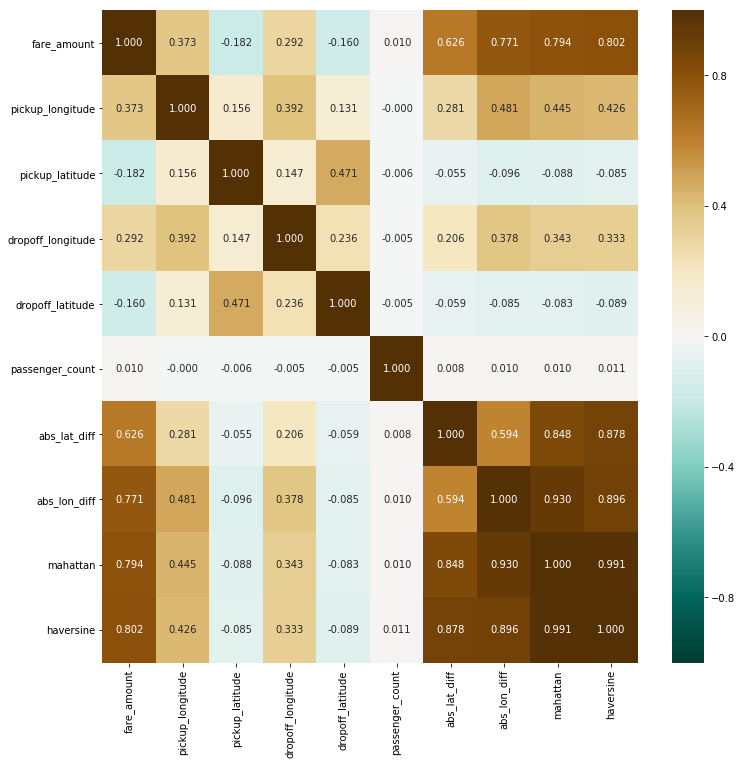

In [272]:
corrs = data.corr()

plt.figure(figsize = (12, 12))
sns.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.BrBG_r);

## so we know that there are features related to distances which are abs_lat_diff, abs_lon_diff, mahattan and haversine, so
## it's better to remove 3 of them and keep only one - maybe haversine

## so we know by feature selection and feature engineering we can improve our results but only linear model will not do
## so we'll have to switch to a non-linear model





# Non-Linear Model: Random Forest

##### This is a powerful ensemble of regression trees that has good performance and generalization ability because of its low variance

In [273]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 20, max_depth = 20, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)

In [274]:
evaluate(random_forest, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'],
         X_train, X_valid, y_train, y_valid)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


Training: rmse = 2.32 mape = 13.7
Validation: rmse = 5.12 mape = 23.21


#### The random forest does much better than the simple linear regression. This indicates that the problem is not completely linear.

In [275]:
preds = random_forest.predict(test[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_random_forest_simple.csv', index = False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


### let's try averaging both the models and see what we get, since sometimes averaging results in performing better than a single model

In [276]:

lr_tpred = lr.predict(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])
rf_tpred = random_forest.predict(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

lr_pred = lr.predict(X_valid[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])
rf_pred = random_forest.predict(X_valid[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

# Average predictions
train_pred = (lr_tpred + rf_tpred) / 2
valid_pred = (lr_pred + rf_pred) / 2

tr, vr, tm, vm = metrics(train_pred, valid_pred, y_train, y_valid)

print('Combined Training: rmse = {} \t mape = {}'.format(round(tr, 2), round(tm, 2)))
print('Combined Validation: rmse = {} \t mape = {}'.format(round(vr, 2), round(vm, 2)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


Combined Training: rmse = 3.54 	 mape = 19.45
Combined Validation: rmse = 5.04 	 mape = 23.5


## slightly better 

### let's try out some more features on Random Forest

In [277]:
def model_rf(X_train, X_valid, y_train, y_valid, test, features,
             model = RandomForestRegressor(n_estimators = 20, max_depth = 20,
                                           n_jobs = -1),
             return_model = False):
    """Train and evaluate the random forest using the given set of features."""
    
    # Train
    model.fit(X_train[features], y_train)
    
    # Validation
    evaluate(model, features, X_train, X_valid, y_train, y_valid)
    
    # Make predictions on test and generate submission dataframe
    preds = model.predict(test[features])
    sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
    
    # Extract feature importances
    feature_importances = pd.DataFrame({'feature': features,
                                        'importance': model.feature_importances_}).\
                           sort_values('importance', ascending = False).set_index('feature')
    
    if return_model:
        return sub, feature_importances, model
    
    return sub, feature_importances

In [278]:
# Evaluate using 8 features
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
                               'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

Training: rmse = 1.86 mape = 12.18
Validation: rmse = 4.54 mape = 20.97


## overfits the training data, we will have look for most important features and eliminate the rest

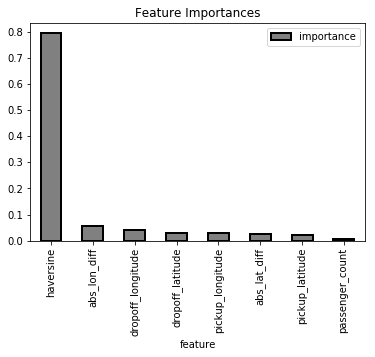

In [279]:
fi.plot.bar(color = 'gray', edgecolor = 'k', linewidth = 2);
plt.title('Feature Importances');

##### The haversine distance is by far the most important with the other features showing considerably less relevance to the model. This suggests that distance is key, and we might want to find a more accurate way of calculating distances.

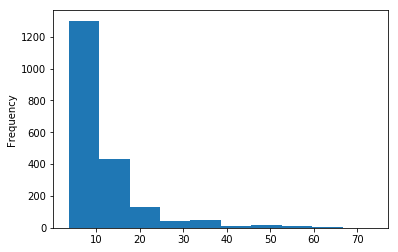

In [280]:
sub.to_csv('sub_rand_forest_8_features.csv', index = False)
sub['fare_amount'].plot.hist();


# Extract Datetime Information

In [281]:
data['pickup_datetime'] = data['pickup_datetime'].str.slice(0, 19)

In [282]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
data['pickup_datetime']

0       2009-06-15 17:26:21+00:00
1       2010-01-05 16:52:16+00:00
2       2011-08-18 00:35:00+00:00
3       2012-04-21 04:30:42+00:00
4       2010-03-09 07:51:00+00:00
5       2011-01-06 09:50:45+00:00
6       2012-11-20 20:35:00+00:00
7       2012-01-04 17:22:00+00:00
8       2012-12-03 13:10:00+00:00
9       2009-09-02 01:11:00+00:00
10      2012-04-08 07:30:50+00:00
12      2009-11-06 01:04:03+00:00
13      2013-07-02 19:54:00+00:00
14      2011-04-05 17:11:05+00:00
16      2014-02-19 07:22:00+00:00
17      2009-07-22 16:08:00+00:00
18      2010-07-07 14:52:00+00:00
19      2014-12-06 20:36:22+00:00
20      2010-09-07 13:18:00+00:00
21      2013-02-12 12:15:46+00:00
22      2009-08-06 18:17:23+00:00
23      2010-12-06 12:29:00+00:00
24      2009-12-10 15:37:00+00:00
25      2011-06-21 16:15:00+00:00
27      2011-06-28 19:47:00+00:00
28      2012-05-04 06:11:20+00:00
29      2013-08-11 00:52:00+00:00
30      2014-02-19 16:03:00+00:00
31      2015-06-21 21:46:34+00:00
32      2009-0

In [309]:
test['pickup_datetime'] = test['pickup_datetime'].str.slice(0, 19)
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
test['pickup_datetime']

0      2015-01-27 13:08:24+00:00
1      2015-01-27 13:08:24+00:00
2      2011-10-08 11:53:44+00:00
3      2012-12-01 21:12:12+00:00
4      2012-12-01 21:12:12+00:00
5      2012-12-01 21:12:12+00:00
6      2011-10-06 12:10:20+00:00
7      2011-10-06 12:10:20+00:00
8      2011-10-06 12:10:20+00:00
9      2014-02-18 15:22:20+00:00
10     2014-02-18 15:22:20+00:00
11     2014-02-18 15:22:20+00:00
12     2010-03-29 20:20:32+00:00
13     2010-03-29 20:20:32+00:00
14     2011-10-06 03:59:12+00:00
15     2011-10-06 03:59:12+00:00
16     2012-07-15 16:45:04+00:00
17     2012-07-15 16:45:04+00:00
18     2012-07-15 16:45:04+00:00
19     2012-07-15 16:45:04+00:00
20     2014-10-29 02:09:56+00:00
21     2014-06-14 13:39:00+00:00
22     2014-06-14 13:39:00+00:00
23     2014-06-14 13:39:00+00:00
24     2014-06-14 13:39:00+00:00
25     2014-06-14 13:39:00+00:00
26     2014-06-14 13:39:00+00:00
27     2014-06-14 13:39:00+00:00
28     2014-06-14 13:39:00+00:00
29     2014-06-14 13:39:00+00:00
          

In [308]:
data = extract_dateinfo(data, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())


In [310]:
test = extract_dateinfo(test, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,manhattan,haversine,...,pickup_is_leap_year,pickup_Hour,pickup_Minute,pickup_Second,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,0.019970,0.008110,0.028080,2.325812,...,False,13,8,24,365,0.547500,0.221071,0.860859,0.075266,191590595.0
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,0.019817,0.012024,0.031841,2.428018,...,False,13,8,24,365,0.547500,0.221071,0.860859,0.075266,191590595.0
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,0.005121,0.002870,0.007991,0.619308,...,False,11,53,44,365,0.495648,0.785093,0.265489,0.769114,87301315.0
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,0.016172,0.009288,0.025460,1.963187,...,True,21,12,12,366,0.883472,0.840496,0.058859,0.917939,123622823.0
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,0.045348,0.022519,0.067867,5.393220,...,True,21,12,12,366,0.883472,0.840496,0.058859,0.917939,123622823.0


## Exploration of Time variables --> to see whether they effect the fares

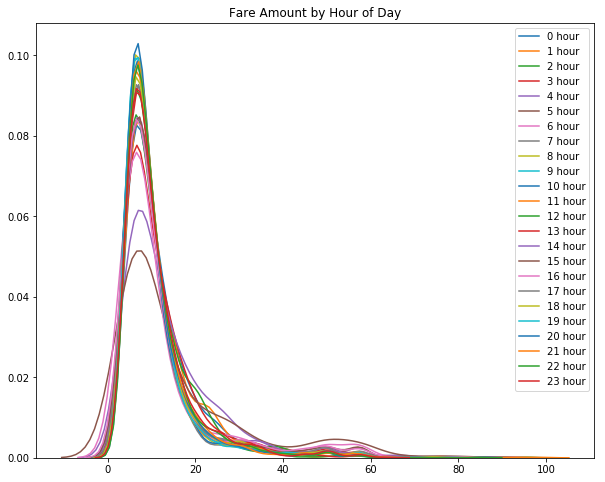

In [291]:
plt.figure(figsize = (10, 8))
for h, grouped in data.groupby('pickup_Hour'):
    sns.kdeplot(grouped['fare_amount'], label = '{} hour'.format(h));
plt.title('Fare Amount by Hour of Day');

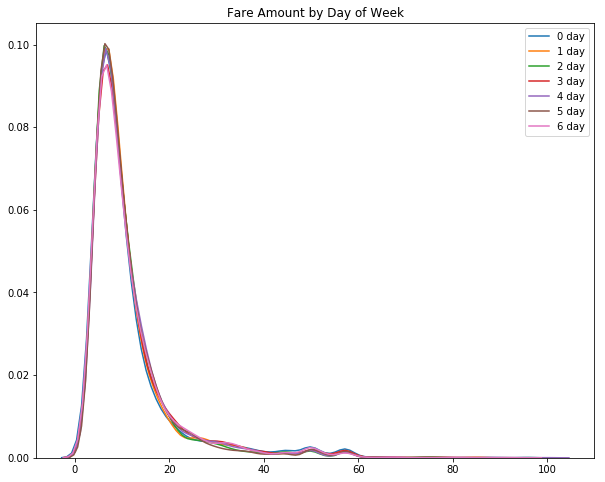

In [293]:
plt.figure(figsize = (10, 8))
for d, grouped in data.groupby('pickup_Dayofweek'):
    sns.kdeplot(grouped['fare_amount'], label = '{} day'.format(d))
plt.title('Fare Amount by Day of Week');



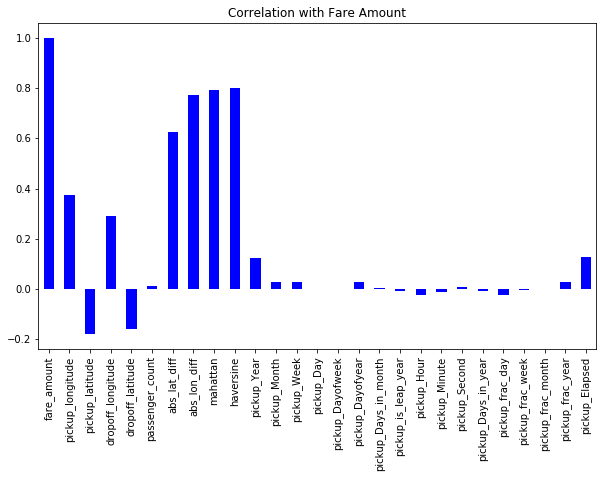

In [295]:
new_correlation = data.corr()
new_correlation['fare_amount'].plot.bar(color = 'b', figsize = (10, 6));
plt.title('Correlation with Fare Amount');


#### It seems the most useful time variables may be the Year or Elapsed because most of the time features have a small correlation with the target. The Elapsed correlation is positive indicating that fares have tended to increase over time.

In [297]:
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = RSEED, test_size = 2000)

In [305]:
time_features = ['pickup_frac_day', 'pickup_frac_week', 'pickup_frac_year', 'pickup_Elapsed']

features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
            'pickup_latitude', 'pickup_longitude', 
            'dropoff_latitude', 'dropoff_longitude'] + time_features

In [306]:
features

['abs_lat_diff',
 'abs_lon_diff',
 'haversine',
 'passenger_count',
 'pickup_latitude',
 'pickup_longitude',
 'dropoff_latitude',
 'dropoff_longitude',
 'pickup_frac_day',
 'pickup_frac_week',
 'pickup_frac_year',
 'pickup_Elapsed']

In [311]:
# Test using the features
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = features)

Training: rmse = 1.62 mape = 10.21
Validation: rmse = 4.19 mape = 18.1


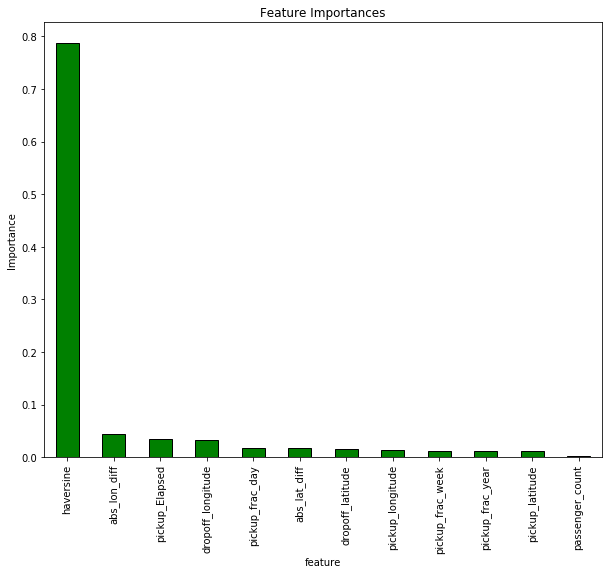

In [313]:
plt.figure(figsize = (10, 8))
fi['importance'].plot.bar(color = 'g', edgecolor = 'k');
plt.ylabel('Importance'); 
plt.title('Feature Importances');

#### Once again, the haversine distance dominates the importance. The time elapsed since the first record seems to be relatively important although the other time features do not seem to be of much use.

In [315]:
# Save submission
sub.to_csv('sub_rf_frac_time.csv', index = False)

## Predictions on Validation set

In [ ]:
random_forest.fit(X_train[features], y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


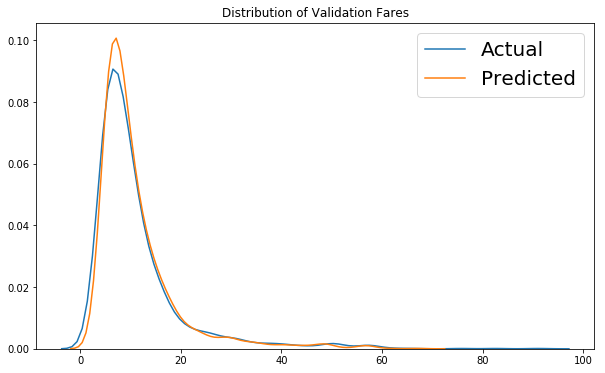

In [324]:
valid_preds = random_forest.predict(X_valid[features])

plt.figure(figsize = (10, 6))
sns.kdeplot(y_valid, label = 'Actual')
sns.kdeplot(valid_preds, label = 'Predicted')
plt.legend(prop = {'size': 20})
plt.title("Distribution of Validation Fares");

In [327]:
analyze = pd.DataFrame({'predicted': valid_preds, 'actual': y_valid})
analyze.describe()


,actual,predicted
count,2000.000000,2000.000000
mean,11.277770,11.211619
std,9.384483,8.255450
min,2.500000,3.580067
25%,6.000000,6.351220
50%,8.500000,8.607216
75%,12.500000,12.706133
max,91.000000,67.055232


##### At this point, our model is probably overfitting because we are using all the features, some of which are highly correlated with one another. One option for feature selection is to use only the most important features from the model.

## Hyperparameter Tuning

In [329]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 100).astype(int),
    'max_depth': [None] + list(np.linspace(5, 30).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestRegressor(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'neg_mean_absolute_error', cv = 3, 
                        n_iter = 100, verbose = 1, random_state=RSEED)

In [330]:
len(data)

47953

In [331]:
tune_data = data.sample(5000, random_state = RSEED)

# Select features
time_features = ['pickup_frac_day', 'pickup_frac_week', 'pickup_frac_year', 'pickup_Elapsed']

features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
            'pickup_latitude', 'pickup_longitude', 
            'dropoff_latitude', 'dropoff_longitude'] + time_features

rs.fit(tune_data[features], np.array(tune_data['fare_amount']))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=100, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'max_leaf_nodes': [None, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15...17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 30]},
          pre_dispatch='2*n_jobs', random_state=100, re

In [333]:
model = rs.best_estimator_
print('The best parameters were {} with a negative mae of {}'.format(rs.best_params_, rs.best_score_))

The best parameters were {'max_leaf_nodes': 43, 'bootstrap': True, 'n_estimators': 65, 'max_features': 0.89999999999999991, 'min_samples_split': 10, 'max_depth': 6} with a negative mae of -2.09661192479


In [335]:
model.n_jobs = -1
model.fit(X_train[features], y_train)

evaluate(model, features, X_train, X_valid, y_train, y_valid)

Training: rmse = 3.57 mape = 20.88
Validation: rmse = 4.48 mape = 20.62


## Final Prediction

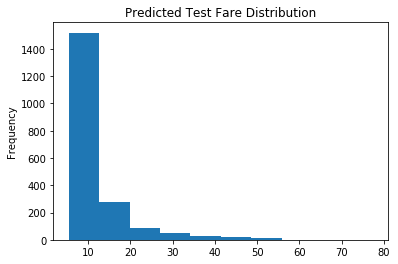

In [338]:
pred = np.array(model.predict(test[features])).reshape((-1))
sub = pd.DataFrame({'key': test_id, 'fare_amount': pred})
sub.to_csv('sub_rf_tuned.csv', index = False)
sub['fare_amount'].plot.hist();
plt.title('Predicted Test Fare Distribution');